# **1. IMPORT MODULES**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import argmax

import string 
import nltk
import re

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

from copy import deepcopy
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from joblib import parallel_backend

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.calibration import CalibratedClassifierCV,calibration_curve

from sklearn.metrics import confusion_matrix,f1_score,classification_report,precision_recall_curve

# **2. DATA OVERVIEW**

In [2]:
df = pd.read_csv("./train.csv") # load data
df.info()                       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [3]:
df.isnull().sum() # Check null values

id       0
label    0
tweet    0
dtype: int64

In [4]:
df.nunique() # Check uniques 

id       31962
label        2
tweet    29530
dtype: int64

In [5]:
df.drop("id",axis = 1,inplace=True) # Drop id column
df.duplicated(keep=False).sum()     # Count duplicates

3126

In [6]:
df = df.drop_duplicates() # Drop all duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29530 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   29530 non-null  int64 
 1   tweet   29530 non-null  object
dtypes: int64(1), object(1)
memory usage: 692.1+ KB


In [7]:
df["label"].value_counts() # Check label distribution

0    27517
1     2013
Name: label, dtype: int64

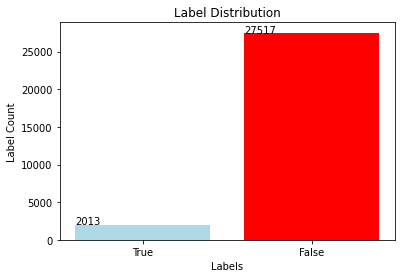

In [8]:
"""
    Display bar graph of labels distribution
    @Param [labelCol] - Column containing label data
"""
def labelGraph(labelCol):
    falseLabels = len(labelCol.loc[(labelCol == 0)])
    trueLabels  = len(labelCol.loc[(labelCol == 1)])

    bars = plt.bar(["True","False"], [trueLabels,falseLabels], color=["lightblue","red"])
    
    # Draw number of label count above bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval + 0.1, yval)

    plt.title("Label Distribution")
    plt.ylabel("Label Count")
    plt.xlabel("Labels")

    plt.show()

labelGraph(df["label"]) # Display bar graph


In [9]:
X = df.iloc[:,1:] # tweets
y = df.iloc[:,:1] # labels

# **3. DATA ANALYSIS AND PREPROCESSING**

In [10]:
"""
    Custom transformer
    Expand dataframe with new features which may have sentimental value.
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class FeaturesExpander(BaseEstimator, TransformerMixin):
    """
        @Param [TEXT_COL] - Column containing tweets
    """
    def __init__(self,TEXT_COL):
        self.__wordstop = stopwords.words("english")
        self.__WHITESPACE = " "
        self.TEXT_COL = TEXT_COL
    """
        Counting words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __WordCount(self,text):
        return len(text.split(self.__WHITESPACE))
    """
        Counting average word length in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __AvgWordLength(self, text):
        return np.mean([len(word) for word in text.split()])
    """
        Counting stop words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __StopwordsCount(self, text):
        return len([word for word in text.split() if word in self.__wordstop])
    """
        Counting uppercase words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __UppercaseCount(self, text):    
        return len([word for word in text.split() if word.isupper()])
    """
        Counting numeric in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __NumericCount(self, text):
        return len([word for word in text.split() if word.isdigit()])
    """
        Counting hashtags in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __HashtagCount(self, text):
        return len([word for word in text.split() if word.startswith("#")])
    """
        Counting mentions in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __MentionCount(self, text):
        return len([word for word in text.split() if word.startswith("@")])
    """
        Counting special characters (emojis,unicodechars,etc..) in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __SpecialCount(selft,text):
        R = "[\u0080-\uFFFF]+" # match any UTF-8 character not in the range of the first 128 characters
        return len([word for word in re.findall(R,text)])
    """
        Expand dataframe with new features 
        @Param [df] - dataframe
        @Return     - New dataframe with new features
    """
    def __Expand(self,df):
        df["Words"] = df[self.TEXT_COL].apply(self.__WordCount)
        df["Avg_Word_Lenght"] = df[self.TEXT_COL].apply(self.__AvgWordLength)
        df["Stopwords"] = df[self.TEXT_COL].apply(self.__StopwordsCount)
        df["Uppercase"] = df[self.TEXT_COL].apply(self.__UppercaseCount)
        df["Numeric"] = df[self.TEXT_COL].apply(self.__NumericCount)
        df["Hashtags"] = df[self.TEXT_COL].apply(self.__HashtagCount)
        df["Mentions"] = df[self.TEXT_COL].apply(self.__MentionCount)
        df["Special_Unicode"] = df[self.TEXT_COL].apply(self.__SpecialCount)
        return df
    """
        Transform data. Expand tweet dataframe with new features.
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with new features
    """
    def transform(self, X, y = None):
        return self.__Expand(X.copy()) 
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """
    def fit(self, X, y = None):
        return self

In [11]:
analysis = FeaturesExpander("tweet").transform(df) # Expand features based on tweet column
analysis.head()

,label,tweet,Words,Avg_Word_Lenght,Stopwords,Uppercase,Numeric,Hashtags,Mentions,Special_Unicode
0,0,@user when a father is dysfunctional and is s...,21,4.555556,10,0,0,1,1,0
1,0,@user @user thanks for #lyft credit i can't us...,22,5.315789,5,0,0,3,2,0
2,0,bihday your majesty,5,5.666667,1,0,0,0,0,0
3,0,#model i love u take with u all the time in ...,17,4.928571,5,0,0,1,0,2
4,0,factsguide: society now #motivation,8,8.000000,1,0,0,1,0,0


In [12]:
analysis.info() # Overview of new features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29530 entries, 0 to 31961
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            29530 non-null  int64  
 1   tweet            29530 non-null  object 
 2   Words            29530 non-null  int64  
 3   Avg_Word_Lenght  29530 non-null  float64
 4   Stopwords        29530 non-null  int64  
 5   Uppercase        29530 non-null  int64  
 6   Numeric          29530 non-null  int64  
 7   Hashtags         29530 non-null  int64  
 8   Mentions         29530 non-null  int64  
 9   Special_Unicode  29530 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 2.5+ MB


In [13]:
"""
    Extract indexes and values
    @Param [data] - dataframe
    @Return       - index
    @Return       - values
"""
def geIdxVal(data):
    idx = data.value_counts().index.tolist()
    vals = data.value_counts().values.tolist()

    return idx,vals
"""
    Add subplot to plot
    @Param [data]   - dataframe
    @Param [ax]     - subplot
    @Param [title]  - Graph title
    @Param [labely] - Label name
    @Param [color]  - Bar color
    @Return         - subplot
"""
def addBarGraph(data,ax,title=None,labely=None,color="lightblue"):
    x,y = geIdxVal(data)

    ax.bar(x, y, color=(color))

    ax.set_title(title)
    ax.set(ylabel=labely)
    ax.autoscale(tight=True)

    return ax
"""
    Merge data into bar graph
    @Param [data1]  - True dataframe 
    @Param [data2]  - False dataframe 
    @Param [ax]     - subplot
    @Param [title]  - Graph title
    @Param [labely] - Label name
    @Return         - subplot
"""
def mergeBarGraph(data1,data2,ax,title=None,labely=None):
    x1,y1 = geIdxVal(data1)
    x2,y2 = geIdxVal(data2)

    ax.bar(x1, y1, color=("red"))
    ax.bar(x2, y2, color=("lightblue"))

    ax.set_title(title)
    ax.set(ylabel=labely)
    ax.autoscale(tight=True)
    ax.legend(["False","True"])

    return ax
"""
    Merge data into scatter graph
    @Param [data1]  - True dataframe 
    @Param [data2]  - False dataframe 
    @Param [ax]     - subplot
    @Param [title]  - Graph title
    @Param [labely] - Label name
    @Return         - subplot
"""
def mergeScatterGraph(data1,data2,ax,labely=None):
    x1,y1 = geIdxVal(data1)
    ax.scatter(x1, y1, color=("red"))
    x2,y2 = geIdxVal(data2)
    ax.scatter(x2, y2, color=("lightblue"))

    ax.set(ylabel=labely)
    ax.autoscale(tight=True)
    ax.legend(["False","True"])
    
    return ax
"""
    Merge data into plot graph
    @Param [data1]  - True dataframe 
    @Param [data2]  - False dataframe 
    @Param [ax]     - subplot
    @Param [title]  - Graph title
    @Param [labely] - Label name
    @Return         - subplot
"""
def mergePlotGraph(data1,data2,ax,labely=None):
    x1,y1 = geIdxVal(data1)
    ax.plot(x1, y1, color=("red"))
    x2,y2 = geIdxVal(data2)
    ax.plot(x2, y2, color=("lightblue"))
    
    ax.set(ylabel=labely)
    ax.autoscale(tight=True)
    ax.legend(["False","True"])
    
    return ax
"""
    Display bar graph
    @Param [data1]  - True dataframe 
    @Param [data2]  - False dataframe 
"""
def barsGraph(analysisTrue,analysisFalse):
    fig, axs = plt.subplots(2,7,figsize=(28,15))

    fig.suptitle("Data\nSize of true label: {0}, Size of false label: {1}".format(len(analysisTrue),len(analysisFalse)),fontsize=16)
    
    axs[0,0] = addBarGraph(analysisTrue["Words"],axs[0,0],"Words","True Frequency") 
    axs[0,1] = addBarGraph(analysisTrue["Avg_Word_Lenght"],axs[0,1],"Avg Word Lenght") 
    axs[0,2] = addBarGraph(analysisTrue["Stopwords"],axs[0,2],"Stopwords") 
    axs[0,3] = addBarGraph(analysisTrue["Uppercase"],axs[0,3],"Uppercase") 
    axs[0,4] = addBarGraph(analysisTrue["Numeric"],axs[0,4],"Numeric") 
    axs[0,5] = addBarGraph(analysisTrue["Hashtags"],axs[0,5],"Hashtags") 
    axs[0,6] = addBarGraph(analysisTrue["Special_Unicode"],axs[0,6],"Special Unicode") 

    axs[1,0] = addBarGraph(analysisFalse["Words"],axs[1,0],None,"False Frequency",color="red") 
    axs[1,1] = addBarGraph(analysisFalse["Avg_Word_Lenght"],axs[1,1],color="red") 
    axs[1,2] = addBarGraph(analysisFalse["Stopwords"],axs[1,2],color="red") 
    axs[1,3] = addBarGraph(analysisFalse["Uppercase"],axs[1,3],color="red") 
    axs[1,4] = addBarGraph(analysisFalse["Numeric"],axs[1,4],color="red") 
    axs[1,5] = addBarGraph(analysisFalse["Hashtags"],axs[1,5],color="red") 
    axs[1,6] = addBarGraph(analysisFalse["Special_Unicode"],axs[1,6],color="red") 
"""
    Display merged bar graph
    @Param [data1]  - True dataframe 
    @Param [data2]  - False dataframe 
"""
def mergedBarsGraph(analysisTrue,analysisFalse):
    fig, axs = plt.subplots(2,7,figsize=(28,15))

    fig.suptitle("Data Comparision\nSize of true label: {0}, Size of false label: {1}".format(len(analysisTrue),len(analysisFalse)),fontsize=16)

    axs[0,0] = mergeBarGraph(analysisFalse["Words"],analysisTrue["Words"],axs[0,0],"Words","Frequency") 
    axs[0,1] = mergeBarGraph(analysisFalse["Avg_Word_Lenght"],analysisTrue["Avg_Word_Lenght"],axs[0,1],"Avg Word Lenght") 
    axs[0,2] = mergeBarGraph(analysisFalse["Stopwords"],analysisTrue["Stopwords"],axs[0,2],"Stopwords") 
    axs[0,3] = mergeBarGraph(analysisFalse["Uppercase"],analysisTrue["Uppercase"],axs[0,3],"Uppercase") 
    axs[0,4] = mergeBarGraph(analysisFalse["Numeric"],analysisTrue["Numeric"],axs[0,4],"Numeric") 
    axs[0,5] = mergeBarGraph(analysisFalse["Hashtags"],analysisTrue["Hashtags"],axs[0,5],"Hashtags") 
    axs[0,6] = mergeBarGraph(analysisFalse["Special_Unicode"],analysisTrue["Special_Unicode"],axs[0,6],"Special Unicode") 

    axs[1,0] = mergeScatterGraph(analysisFalse["Words"],analysisTrue["Words"],axs[1,0],"Frequency") 
    axs[1,1] = mergeScatterGraph(analysisFalse["Avg_Word_Lenght"],analysisTrue["Avg_Word_Lenght"],axs[1,1]) 
    axs[1,2] = mergeScatterGraph(analysisFalse["Stopwords"],analysisTrue["Stopwords"],axs[1,2]) 
    axs[1,3] = mergePlotGraph(analysisFalse["Uppercase"],analysisTrue["Uppercase"],axs[1,3]) 
    axs[1,4] = mergePlotGraph(analysisFalse["Numeric"],analysisTrue["Numeric"],axs[1,4]) 
    axs[1,5] = mergePlotGraph(analysisFalse["Hashtags"],analysisTrue["Hashtags"],axs[1,5]) 
    axs[1,6] = mergePlotGraph(analysisFalse["Special_Unicode"],analysisTrue["Special_Unicode"],axs[1,6]) 

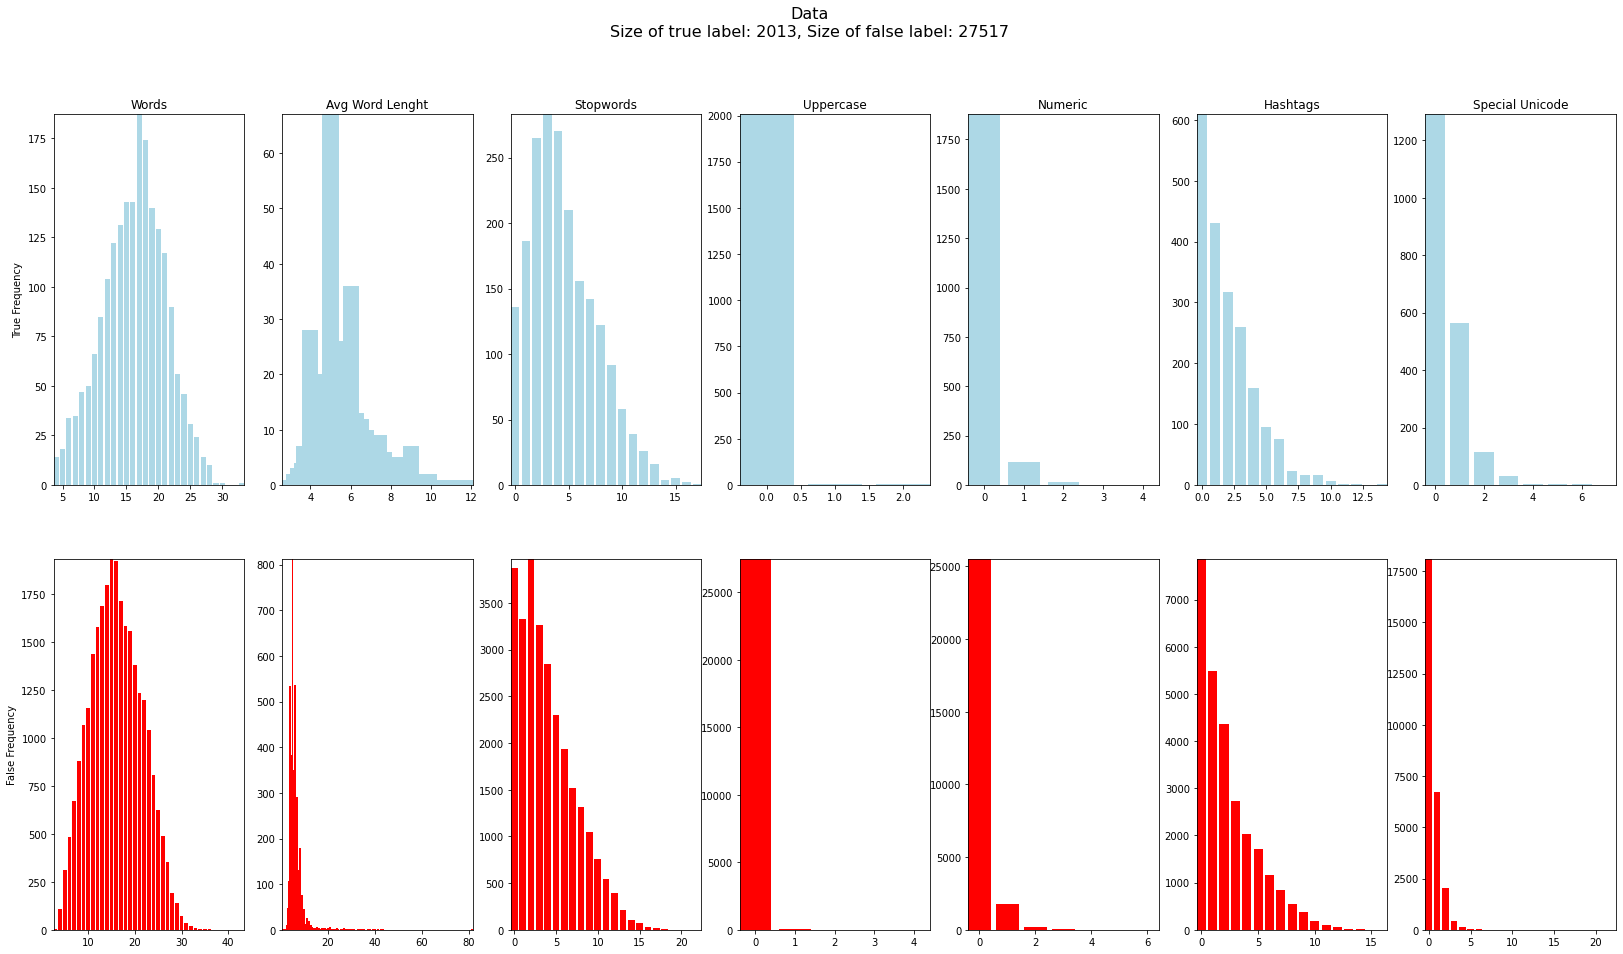

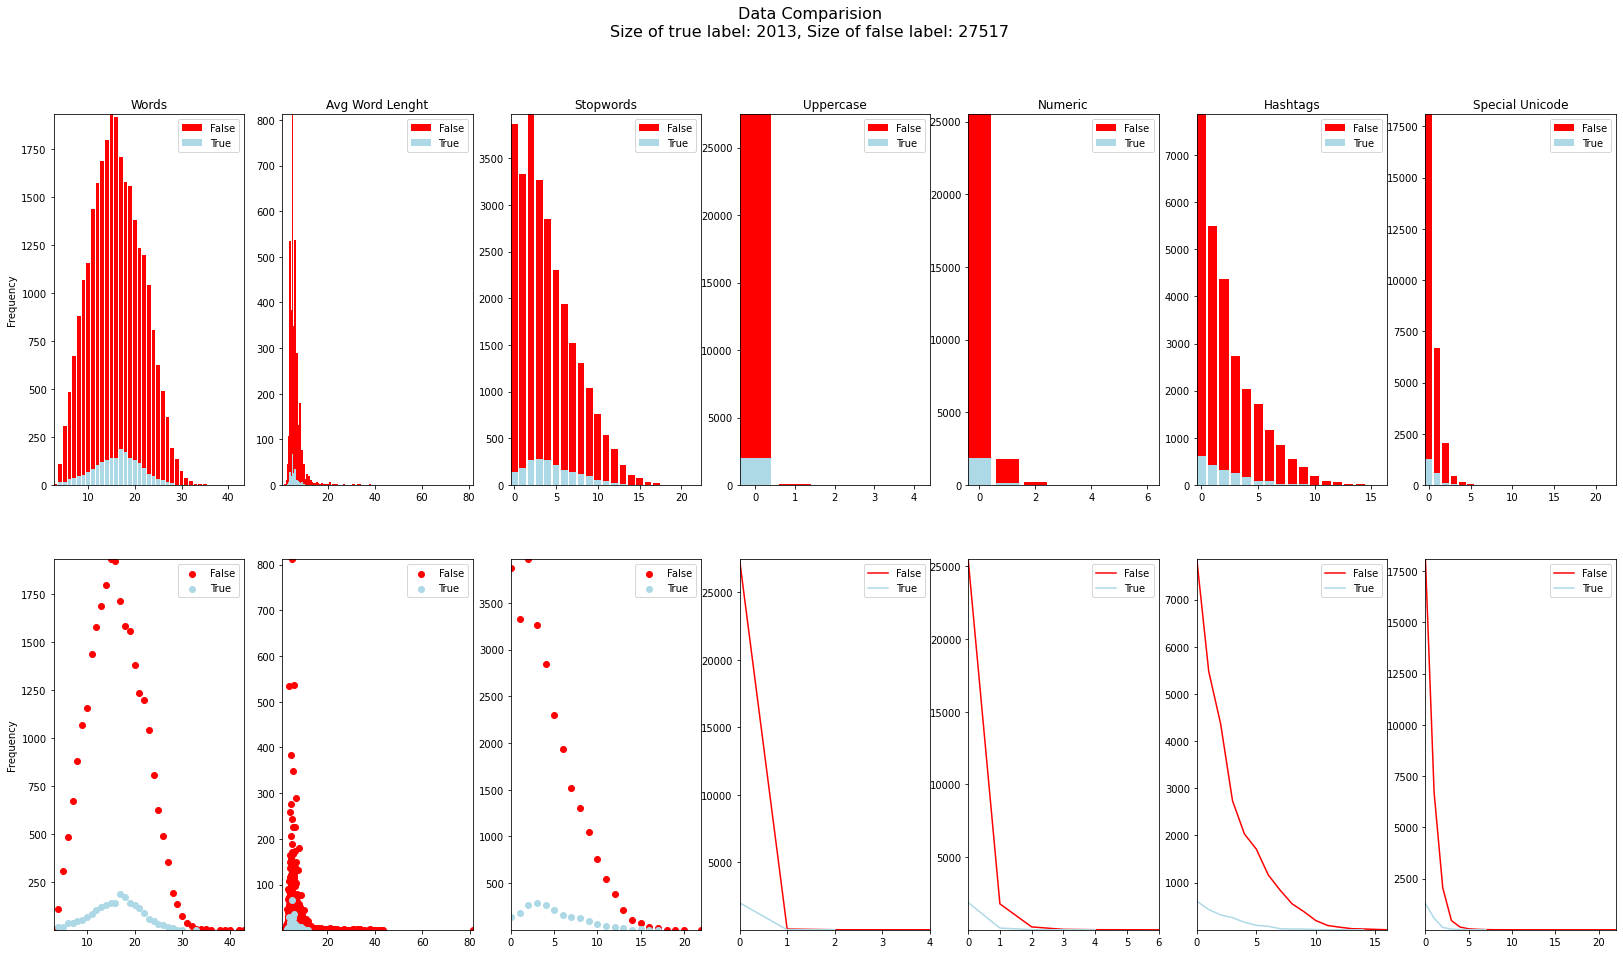

In [14]:
analysisTrue = analysis.loc[(analysis["label"] == 1)]   # Only True labels
analysisFalse = analysis.loc[(analysis["label"] == 0)]  # Only False labels

barsGraph(analysisTrue,analysisFalse)       # Display features distribution in graphs
mergedBarsGraph(analysisTrue,analysisFalse) # Compare graphs on one plot

In [15]:
"""
    Custom transformer
    Clean text.
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.__Lemmatizer = WordNetLemmatizer()
        self.__wordstop = stopwords.words("english")
        self.__Spell = Speller()
        self.__WHITESPACE = " "
        self.__EMPTY_STRING = ""
    """
        Clean text to words only
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __CleanText(self, text):
        REGEX = [
            "\n\t",                  # new lines, tabs 
            "https?://\S+|www\.\S+", # URL = http,https,www #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
            "@[\w\-]+",              # MENTION = Tweet mention
            "<.*?>+|\[.*?\]",        # ATTRIBUTES = <zero or more characters> or [zero or more character]
            "\w*\d\w*"               # NUMBERS = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
        ]  
        for R in REGEX: 
            text = re.sub(R, self.__EMPTY_STRING, text)

        return text.strip().encode("ascii", "ignore").decode("ascii") # Remove emojis and strip text
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __Lemmatize(self, text):
        lemmatized = [self.__Lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
        return self.__WHITESPACE.join(lemmatized) 
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __RemStopwords(self, text):
        noStopwords = [word for word in nltk.word_tokenize(text) if not word in self.__wordstop]
        return self.__WHITESPACE.join(noStopwords) 
    """
        Correct the spelling of the word.
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __Autocorrect(self, text):  
        spells = [self.__Spell(word) for word in (nltk.word_tokenize(text))]
        return self.__WHITESPACE.join(spells) 
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __RemPunctuation(self, text):
        REGEX_PUNCTUATION = "[%s]" # any punctuation
        return re.sub(REGEX_PUNCTUATION % re.escape(string.punctuation),self.__EMPTY_STRING, text)
    """
        Clean tweets to bag of words
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __SimpleClean(self,text):
        text = text.lower() 
        sentenceToken = nltk.sent_tokenize(text)
        words = []
        for sentence in sentenceToken:
            cleaned = self.__CleanText(sentence)
            corrected = self.__Autocorrect(cleaned)
            noStopwords = self.__RemStopwords(corrected)
            noPunct = self.__RemPunctuation(noStopwords)
            lemmatizzed = self.__Lemmatize(noPunct)

            wordToken = nltk.word_tokenize(lemmatizzed)
            for word in wordToken:
                words.append(word)

        return self.__WHITESPACE.join(words)
    """
        Transform data. Clean tweets
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with cleaned tweet
    """
    def transform(self, X, y = None):
        return X.copy().apply(self.__SimpleClean)
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """  
    def fit(self, X, y = None):
        return self

In [16]:
example = FeaturesExpander("tweet").transform(X[:100])        # Create example using 100 entries
example["tweet"] = Preprocessor().transform(example["tweet"]) # Apply preprocessor class on tweet
example.head() 

,tweet,Words,Avg_Word_Lenght,Stopwords,Uppercase,Numeric,Hashtags,Mentions,Special_Unicode
0,father dysfunctional selfish drag kid dysfunct...,21,4.555556,10,0,0,1,1,0
1,thanks left credit ca nt use cause nt offer wh...,22,5.315789,5,0,0,3,2,0
2,birthday majesty,5,5.666667,1,0,0,0,0,0
3,model love u take u time ur,17,4.928571,5,0,0,1,0,2
4,factsguide society motivation,8,8.000000,1,0,0,1,0,0


In [17]:
"""
    Custom transformer
    Remove most frequent and most rare words
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class FrequentWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.__WORDS_MAX = 10 # Delete top 10 frequent words
        self.__WORDS_MIN = 0 
        self.__WORDS_MIN_PERCENTAGE = 0.75 # Delete 75% od rare words
        self.__WHITESPACE = " "
        self.__most = []
        self.__rare = []
    """
        Remove most frequent and most rare words, if tweet is empty after removal don"t remove words from tweet
        @Param [source] - tweet
        @Param [source] - words to delete
        @Return         - modified tweet or previous tweet
    """
    def __RemWords(self, source, words):
        removed = []
        for sentence in source:
            newSentence = []
            for word in sentence.split():
                if word not in words:
                    newSentence.append(word)
            if len(newSentence) == 0:
                removed.append(sentence)
            else:
                removed.append(self.__WHITESPACE.join(newSentence))
        return removed
    """e
        Extract most rare words 
        @Param [frequent] - all words with frequency
        @Return           - most rare words
    """
    def __GetWordsMin(self,frequent):
        rareLen = len(frequent[frequent == 1])
        return int(self.__WORDS_MIN_PERCENTAGE * rareLen)
    """
        Handles removing words
        @Param [tweet] 
        @Return        - new tweet
    """
    def __Remove(self,tweet):
        frequent = pd.Series(self.__WHITESPACE.join(tweet).split()).value_counts()
        self.__most = frequent[:self.__WORDS_MAX]

        self.__WORDS_MIN = self.__GetWordsMin(frequent)
        self.__rare = frequent[-1 * self.__WORDS_MIN:]

        tweet = self.__RemWords(tweet,list(self.__most.index)) 
        tweet = self.__RemWords(tweet,list(self.__rare.index))

        return tweet
    """
        Transform data. Remove frequent words
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with cleaned tweet
    """
    def transform(self, X, y = None):
        return self.__Remove(X.copy())
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """   
    def fit(self, X, y = None):
        return self
    """
        Show most rare and most frequent words
    """
    def Show(self):
        print("{0} Most Frequent Words:".format(self.__WORDS_MAX))
        print(self.__most,"\n")
        print("{0} ({1} %) Most Rare Words:".format(self.__WORDS_MIN,self.__WORDS_MIN_PERCENTAGE*100))
        print(self.__rare)

In [18]:
F = FrequentWords()
example["tweet"] = F.transform(example["tweet"]) # Remove frequent words from tweets
F.Show()                                         # Display removed words 

10 Most Frequent Words:
s         11
nt         8
day        8
love       8
people     7
get        6
father     6
happy      5
work       5
time       5
dtype: int64 

346 (75.0 %) Most Rare Words:
offline     1
episode     1
watching    1
fuss        1
jam         1
           ..
cheering    1
singing     1
gaa         1
passed      1
change      1
Length: 346, dtype: int64


In [19]:
cv = CountVectorizer(ngram_range = (1,2))        # Using ngrams (unigrams and bigrams)
countMatrix = cv.fit_transform(example["tweet"]) # Bag of words
countMatrix

<100x531 sparse matrix of type '<class 'numpy.int64'>'
	with 628 stored elements in Compressed Sparse Row format>

In [20]:
countMatrix.toarray()[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
cv.vocabulary_ # Display corpus 

{'selfish': 407,
 'kid': 227,
 'selfish kid': 408,
 'ca': 49,
 'use': 488,
 'ca use': 53,
 'birthday': 36,
 'take': 455,
 'factsguide': 119,
 'society': 430,
 'motivation': 289,
 'factsguide society': 120,
 'society motivation': 431,
 'fan': 123,
 'talking': 457,
 'fan talking': 127,
 'camping': 59,
 'tomorrow': 473,
 'danny': 91,
 'camping tomorrow': 60,
 'tomorrow danny': 474,
 'school': 395,
 'year': 525,
 'exam': 112,
 'think': 469,
 'girl': 167,
 'school year': 397,
 'year year': 528,
 'year exam': 526,
 'exam ca': 113,
 'ca think': 52,
 'think school': 470,
 'school exam': 396,
 'exam girl': 114,
 'cap': 61,
 'ireland': 217,
 'mom': 280,
 'ireland mom': 219,
 'orlando': 321,
 'selfish orlando': 409,
 'orlando selfish': 322,
 'see': 400,
 'today': 471,
 'see today': 401,
 'call': 54,
 'call school': 55,
 'helpcovedolphins': 196,
 'helpcovedolphins helpcovedolphins': 197,
 'junior': 224,
 'omg': 315,
 'junior junior': 225,
 'junior omg': 226,
 'thankful': 462,
 'positive': 349,
 't

In [22]:
# Display bag of words
countTokens = cv.get_feature_names()
dfCount = pd.DataFrame(data=countMatrix.toarray(),columns=countTokens)
dfCount.head(10)

,acceptance,acceptance letter,acid,acid first,agree,alohafriday,alohafriday exist,amp,amp everything,around,...,wrapping,wrapping senseaboutmaths,yeah,yeah thejourneybegins,year,year exam,year old,year year,yes,yes received
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Convert a collection of raw documents to a matrix of TF-IDF features
# Reflect how important a word is to a document in a collection or corpus.
tfid = TfidfTransformer() 
tfidMatrix = tfid.fit_transform(countMatrix)
tfidMatrix

<100x531 sparse matrix of type '<class 'numpy.float64'>'
	with 628 stored elements in Compressed Sparse Row format>

In [24]:
# Create and display TF-IDF features
tfidCount = pd.DataFrame(data=tfidMatrix.toarray(),columns=countTokens) 
tfidCount.head(10)

,acceptance,acceptance letter,acid,acid first,agree,alohafriday,alohafriday exist,amp,amp everything,around,...,wrapping,wrapping senseaboutmaths,yeah,yeah thejourneybegins,year,year exam,year old,year year,yes,yes received
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.377981,0.219968,0.0,0.219968,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


# **4. PREPROCESSING PIPELINE**

In [25]:
"""
    Custom transformer
    Select only specified column
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    """
        Transform data. Select only specified column
        @Param [data_dict] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Specified tweet
    """
    def transform(self, data_dict,y=None):
        return data_dict[self.key]
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """  
    def fit(self, x, y=None):
        return self

textPreprocessing = Pipeline([                         # Tweet preprocessing pipeline
    ("clear",Preprocessor()),                          # Clear text
    ("remFreq",FrequentWords()),                       # Remove frequent words
    ("tfidf",TfidfVectorizer(ngram_range = (1,2)))     # Equivalent to:
                                                       # ("bow", CountVectorizer(ngram_range = (1,2))),   # strings to token integer counts CountVectorizer(min_df=1,max_df=2)
                                                       # ("tfidf", TfidfTransformer()),                   # integer counts to weighted TF-IDF scores
])

numericalPreprocessing = Pipeline([                                 # Numeric preprocessing pipeline
    ("NANs", SimpleImputer(missing_values=np.nan, strategy="mean")) # Deal with nan values
])     

textCol = ["tweet"] # Tweet column
numericalCol = ["Words","Avg_Word_Lenght","Stopwords","Uppercase","Numeric","Hashtags","Mentions","Special_Unicode"] # Numeric columns

preprocess = FeatureUnion([                              # Put preprocessors in pipeline
    ("text", Pipeline([
        ("selectorTweet", ItemSelector(key=textCol[0])), # Select tweet columns
        ("textPreprocessing", textPreprocessing)         # Text preprocessing pipeline
    ])),
    ("num", Pipeline([                                   
       ("selectorNum", ItemSelector(key=numericalCol)),  # Select numeric columns
       ("numPreprocessing", numericalPreprocessing)      # Preprocess numerics
       ])
    )
])   

preprocessingPip = Pipeline([                   # Create preprocessing pipeline
    ("expander", FeaturesExpander(textCol[0])), # Expand features
    ("preprocess", preprocess)                  # Preprocess features
])

# **5. BALANCED/IMBALANCED SET**

In [26]:
# Split data into:
# 60% - train set      - used to train data
# 20% - validation set - validate models
# 20% - test set       - final test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [27]:
# By combining Over Sampling and Under Sampling, we might not lose major datapoints.

# Perform Over Sampling
Ros = RandomOverSampler(random_state=0, sampling_strategy=0.4)
X_Ros, y_Ros = Ros.fit_resample(X_train, y_train) 

# Perform Under Sampling on oversampled data
Rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_Ballanced, y_Ballanced = Rus.fit_resample(X_Ros, y_Ros)

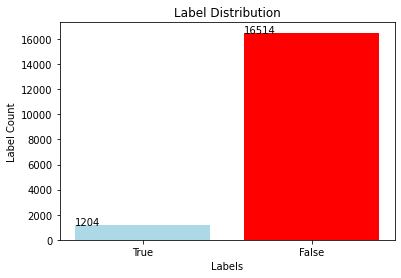

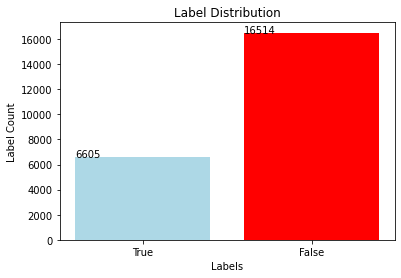

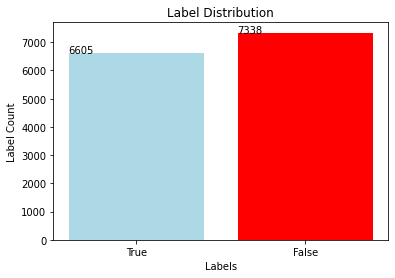

In [28]:
labelGraph(y_train["label"])     # Previous data set
labelGraph(y_Ros["label"])       # Over sampled data set
labelGraph(y_Ballanced["label"]) # Using Under Sampling on oversampled data

# **6. MODELS EVALUATION**

In [29]:
"""
    @Param [preprocessPip]
    @Param [x]                  - Tweets to preprocess
    @Param Optional [transform] - Transform model instead fit_transform
    @Return                     - Preprocessed X
"""
def preProcessTweets(preprocessPip,x,transform = False):
    print("Preprocessing tweets...")  
    with parallel_backend("threading", n_jobs=-1):      # Using threading
        if transform:
            return deepcopy(preprocessPip).transform(x) # Deep copy makes sure to not modify preprocessing pipeline
        else:
            return preprocessPip.fit_transform(x)
"""
    @Param [pipeline] - Preprocessing pipeline
    @Param [models]   - Models to train
    @Param [x]        - Training data features
    @Param [y]        - Training data label
    @Return           - Trainend models
"""
def trainModels(pipeline,models,x,y):
    preprocessPip = clone(pipeline)
    newX = preProcessTweets(preprocessPip,x)

    trainedModels = {} 
    for key in models:
        name = key                 # Get model name
        model = clone(models[key]) # Get clean model

        print("Training {0} model...".format(name)) 
        with parallel_backend("threading", n_jobs=-1): # Using threading
            model.fit(newX,y)

        # Create trained pipeline with preprocessor and model
        modelPip = Pipeline([ # cloning
            ("preprocess",preprocessPip),
            ("clf",model)
        ])
        
        trainedModels.update({name:modelPip})
    print("Returning trained models...\n")
    return trainedModels

# Models to train
models = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "Multinomial": MultinomialNB(),
    "Bernoulli": BernoulliNB(),
    "SVC": SVC(probability=True)
}

In [30]:
inbalanced = trainModels(preprocessingPip,models,X_train, y_train["label"])       # Train models on imbalanced data
balanced = trainModels(preprocessingPip,models,X_Ballanced, y_Ballanced["label"]) # Train models on balanced data

Preprocessing tweets...
Training DecisionTree model...
Training RandomForest model...
Training Multinomial model...
Training Bernoulli model...
Training SVC model...
Returning trained models...

Preprocessing tweets...
Training DecisionTree model...
Training RandomForest model...
Training Multinomial model...
Training Bernoulli model...
Training SVC model...
Returning trained models...



In [31]:
"""
    Predict probabilities and evaluate models based on brier score
    @Param [models]   - Models in pipelines
    @Param [x]        - Validation data features
    @Param [y]        - Validation data label
    @Return           - Dataframe with scores
"""
def evaluateModels(models,x,y):
    vals = models.values()
    iterator = iter(vals)
    preprcsor = next(iterator)["preprocess"]

    newX = preProcessTweets(preprcsor,x,True)

    index = []
    scores = []
    for key in models:
        name = key                 # Get model name
        model = models[key]["clf"] # Get model

        print("Evaluating {0} model...".format(name)) 
        with parallel_backend("threading", n_jobs=-1): # Using threading
            probs = model.predict_proba(newX)
            
        probs = probs[:, 1]               # Select only true labels
        loss = brier_score_loss(y, probs) # Evaluate model score 
        
        scores.append(loss)
        index.append(name)
    
    print("Returning results...")
    return pd.DataFrame(scores, columns = ["Scores"], index=index)

print("Balanced data:")
bl  = evaluateModels(balanced,X_val,y_val["label"])   # Predict probabilities on models trainend on balanced set
print("\nImbalanced data:")
inb = evaluateModels(inbalanced,X_val,y_val["label"]) # Predict probabilities on models trainend on imbalanced set

Balanced data:
Preprocessing tweets...
Evaluating DecisionTree model...
Evaluating RandomForest model...
Evaluating Multinomial model...
Evaluating Bernoulli model...
Evaluating SVC model...
Returning results...

Imbalanced data:
Preprocessing tweets...
Evaluating DecisionTree model...
Evaluating RandomForest model...
Evaluating Multinomial model...
Evaluating Bernoulli model...
Evaluating SVC model...
Returning results...


# **7. CHOOSE TWO BEST MODELS**

In [32]:
results = pd.concat([inb,bl],axis=1,sort=True)                    # Concat scores
results.set_axis(["Imbalanced","Balanced"], axis=1, inplace=True) # Name columns
results.head()

,Imbalanced,Balanced
Bernoulli,0.070437,0.045286
DecisionTree,0.068236,0.140874
Multinomial,0.070437,0.071447
RandomForest,0.038720,0.043862
SVC,0.039077,0.200050


In [33]:
"""
    Select and return clean best model based on scores 
    @Param [results]  - Results dataframe
    @Param [models]   - All models 
    @Param [pipeline] - Preprocessing pipeline
    @Return           - Model name
    @Return           - Best model in pipeline
"""
def bestModel(results,models,pipeline):
    lowestIdx = results.idxmin()
    lowest = results.min()

    bestModel = None
    lowestResult = lowest.min()

    for i in range(len(lowest)):
        if lowest[i] == lowestResult:
            
            # Create clean pipeline with preprocessor and model
            bestModel = clone(Pipeline([ # cloning
                ("preprocess",pipeline),
                ("clf",models[lowestIdx[i]])
            ]))

            print("Best Model:   {0}\nBrier Score:  {1}\nDataset Type: {2}".format(lowestIdx[i],lowest[i],lowest.index[i]))
            
            modelName = lowestIdx[i]
            return modelName,bestModel

In [34]:
# Find best cored model with data set
modelName,firstModel = bestModel(results,models,preprocessingPip)

Best Model:   RandomForest
Brier Score:  0.038719556383338974
Dataset Type: Imbalanced


In [35]:
results = results.drop(index=modelName,axis=1) # Remove best model to find second best
# Find best cored model with data set
modelName,secondModel = bestModel(results,models,preprocessingPip)

Best Model:   SVC
Brier Score:  0.03907687824696874
Dataset Type: Imbalanced


In [36]:
# Free memory
del Ros,X_Ros,y_Ros,Rus,X_Ballanced,y_Ballanced,inbalanced,balanced,models,tfidMatrix,tfidCount,tfid,dfCount,countTokens,countMatrix,cv,F,example,analysisTrue,analysisFalse,analysis

# **8. HYPERPARAMETER TUNNING**

In [37]:
"""
    Tune best hyperparamters
    @Param [search]   - Tunning algorithm
    @Param [x]        - Validation data features
    @Param [y]        - Validation data label
    @Return           - Search method
"""
def fitSearch(search,x,y):
    with parallel_backend("threading", n_jobs=-1): # Using threading
        search.fit(x, y)
    print("\nBest Score: {0}".format(search.best_score_))
    print("Best Hyperparameters:\n{0}".format(search.best_params_))

    return search
"""
    Decide which search was better and return best model
    @Param [preprocessingPip]
    @Param [randomSearch]   
    @Param [bayesSearch]
    @Return              - Best model with tunned hyperparameters in pipeline
"""
def pickBest(preprocessingPip,randomSearch,bayesSearch):
    if bayesSearch.best_score_ >= randomSearch.best_score_:
        print("\nBayesSearchCV achieved better score\nReturning model...")
        return clone(Pipeline([ # cloning
                ("preprocess",preprocessingPip),
                ("clf",bayesSearch.best_estimator_)
        ])) 
    else:
        print("\nRandomizedSearchCV achieved better score\nReturning model...")
        return clone(Pipeline([ # cloning
                ("preprocess",preprocessingPip),
                ("clf",randomSearch.best_estimator_)
        ])) 

"""
    Compare Randomized search and Bayes search based on neg_brier_score. Return best hyperparameters.
    @Param [modelPip] - Model in pipeline
    @Param [grid]     - Hyperparameters gird
    @Param [x]        - Validation data features
    @Param [y]        - Validation data label
    @Return           - Tunned model in pipeline
"""
def tuneParams(modelPip,grid,x,y): 
    newX = preProcessTweets(clone(modelPip["preprocess"]),x)

    randomSearch = RandomizedSearchCV(estimator = clone(modelPip["clf"]), 
                                    param_distributions = grid, 
                                    n_iter = 10,                # Total iterations
                                    cv = 2,                     # Number of folds
                                    verbose=2,           
                                    random_state=42,            # Random seed
                                    scoring="neg_brier_score")  # Scoring algorithm

    bayesSearch = BayesSearchCV(estimator = clone(modelPip["clf"]), 
                                search_spaces = grid, 
                                n_iter = 10, 
                                cv = 2, 
                                verbose=2, 
                                random_state=42,
                                scoring="neg_brier_score")

    print("Starting Randomized Search...")
    randomSearch = fitSearch(randomSearch,newX,y) 

    print("\nStarting Bayes Search...")
    bayesSearch = fitSearch(bayesSearch,newX,y) 

    return pickBest(modelPip["preprocess"],randomSearch,bayesSearch) # Compare and return tunned model

In [38]:
gridForest = {"n_estimators": [int(trees) for trees in np.linspace(start = 100, stop = 2000, num = 10)], # Number of trees in random forest
              "max_features": ["auto", "sqrt"],                                                          # Number of features to consider at every split
              "max_depth": [int(levels) for levels in np.linspace(10, 100, num = 10)] + [None],          # Maximum number of levels in tree
              "min_samples_split": [2, 5, 10],                                                           # Minimum number of samples required to split a node
              "min_samples_leaf": [1, 2, 4],                                                             # Minimum number of samples required at each leaf node
              "bootstrap":[True, False]                                                                  # Method of selecting samples for training each tree
}     
gridForest # Display gird

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [39]:
# Find best hyperparameters and compare randomized search and Bayes Search
firstModel = tuneParams(firstModel,gridForest,X_train, y_train["label"])

Preprocessing tweets...
Starting Randomized Search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  19.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  19.6s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  22.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  28.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944; total time= 4.3min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944; total time= 5.3min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_sam

In [41]:
gridSVC = {
  "C": [0.1, 1, 10, 100, 1000],                  # Penalty
  "kernel": ["linear","rbf","sigmoid","poly"],   # Hyperplane used to separate the data
  "gamma": [1, 0.1 ,0.01, 0.001, 0.0001]         # Tries to exactly fit the training data set
}

gridSVC # Display gird

{'C': [0.1, 1, 10, 100, 1000],
 'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [42]:
# Find best hyperparameters and compare randomized search and Bayes Search
secondModel = tuneParams(secondModel,gridSVC,X_train, y_train["label"])

Preprocessing tweets...
Starting Randomized Search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=  19.8s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=  20.1s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time= 1.3min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  18.9s
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  18.8s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  16.9s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=  15.0s
[CV] END .......................C=1000, gamma=1, kernel=poly; total time= 2.1min
[CV] END .......................C=1000, gamma=1, kernel=poly; total time= 2.2min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 2

# **9. MODEL CALIBRATION**

In [43]:
"""
    Calibrate models based on sigmoid method
    @Param [model]    - Clean model
    @Param [x]        - Training data features
    @Param [y]        - Training data label
    @Return           - Calibrated model
"""
def calibrate(model,x,y):
    model = clone(Pipeline([ # cloning
        ("preprocess",model["preprocess"]),
        ("clf",CalibratedClassifierCV(model["clf"], method="sigmoid", cv=5))
    ]))

    print("Calibrating model...")
    with parallel_backend("threading", n_jobs=-1): # Using threading
        return model.fit(x,y) 

firstModel = calibrate(firstModel,X_train, y_train["label"])
secondModel = calibrate(secondModel,X_train, y_train["label"])

Calibrating model...
Calibrating model...


In [45]:
# Predict probabilities of true labels on validation data set
probaFirst = firstModel.predict_proba(X_val)[:, 1]
probaSecond = secondModel.predict_proba(X_val)[:, 1]

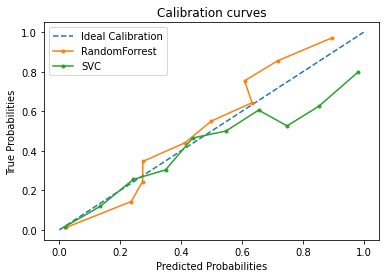

In [56]:
# plot the calibration curve and compare calibration of models
x_p1, y_p1 = calibration_curve(y_val["label"], probaFirst, n_bins=10, normalize="True") 
x_p2, y_p2 = calibration_curve(y_val["label"], probaSecond, n_bins=10, normalize="True") 

plt.plot([0, 1], [0, 1],linestyle="--",label="Ideal Calibration")
plt.plot(x_p1, y_p1,marker=".",label="RandomForrest")
plt.plot(y_p2,x_p2,marker=".",label="SVC")
plt.xlabel("Predicted Probabilities")
plt.ylabel("True Probabilities")
plt.title("Calibration curves")
plt.legend()
plt.show()

# **10. THRESHOLD TUNNING**

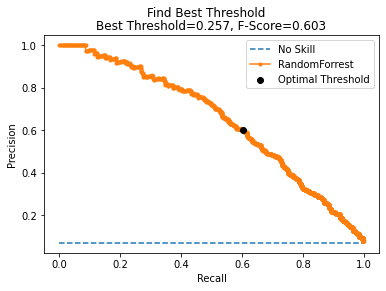

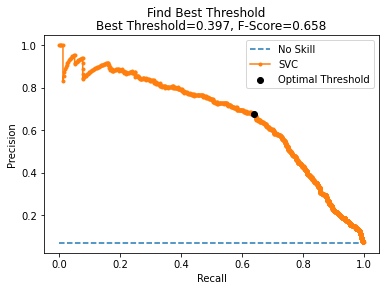

In [57]:
"""
    "Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only"
    Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    @Param [classifier] - Classifier name
    @Param [proba]      - Probability of being True 
    @Param [y]          - Actual label
    @Return             - Optimal threshold
"""
def tuneThreshold(y,proba,classifier):
    precision, recall, thresholds = precision_recall_curve(y["label"], proba)
    no_skill = len(y.loc[(y["label"] == 1)]) / len(y["label"])
 
    fscore = (2 * precision * recall) / (precision + recall) # convert to f score
    i = argmax(fscore)# locate the index of the largest f score
    
    # plot the roc curve for the model
    plt.plot([0,1], [no_skill,no_skill], linestyle="--", label="No Skill")
    plt.plot(recall, precision, marker=".", label=classifier)
    plt.scatter(recall[i], precision[i], marker="o", color="black", label="Optimal Threshold",zorder=3)

    # axis labels
    plt.suptitle("Find Best Threshold")
    plt.title("Best Threshold={0}, F-Score={1}".format(round(thresholds[i],3), round(fscore[i],3)))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    
    # show the plot
    plt.show()
   
    return thresholds[i]

# Find optimal threshold uing precision-recall curve. Focusing on positive labels as precision is important to us.
threshFirst = tuneThreshold(y_val,probaFirst,"RandomForrest") 
threshSecond = tuneThreshold(y_val,probaSecond,"SVC")

# **11. MODEL SCORE**

In [50]:
# Predict probabilities for labels
with parallel_backend("threading", n_jobs=-1): # Using threading
    probaTest1 = firstModel.predict_proba(X_test)
    probaTest2 = secondModel.predict_proba(X_test)

In [51]:
# Compare models using brier score
loss1 = brier_score_loss(y_test["label"], probaTest1[:, 1])
loss2 = brier_score_loss(y_test["label"], probaTest2[:, 1])

print("RandomTree Model:")
print("Brier Loss: {0}".format(loss1))
print("\nSVC Model:")
print("Brier Loss: {0}".format(loss2))

RandomTree Model:
Brier Loss: 0.03807831113908791

SVC Model:
Brier Loss: 0.03712829878057691


In [52]:
# Apply optimal threshold
predTest1 = (probaTest1 [:, 1] >= threshFirst) 
predTest2 = (probaTest2 [:, 1] >= threshSecond)

RandomForestClassifier Results:


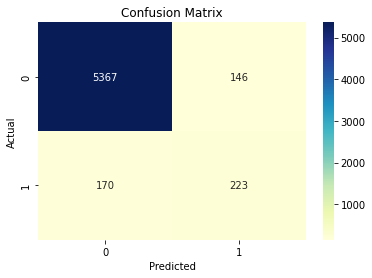

			Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5513
           1       0.60      0.57      0.59       393

    accuracy                           0.95      5906
   macro avg       0.79      0.77      0.78      5906
weighted avg       0.95      0.95      0.95      5906

F1 Score: 0.5853018372703411


In [53]:
"""
    Display confussion matrix, classification report and F1 Score
    @Param [pred]       - Predicted labels
    @Param [y]          - Actual labels
"""
def displayResults(y, pred):
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm,annot=True,cmap="YlGnBu", fmt="d")

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual") 
    plt.show()

    print("\t\t\tClassification Report\n{0}".format(classification_report(y, pred)))
    print("F1 Score: {0}".format(f1_score(y, pred)))

# Display results for RandomForestClassifier
print("RandomForestClassifier Results:")
displayResults(y_test["label"], predTest1)

SVC Results:


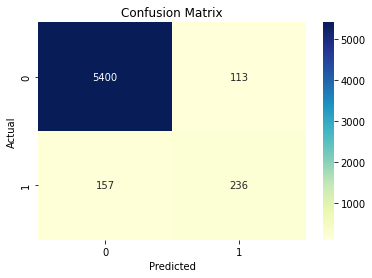

			Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5513
           1       0.68      0.60      0.64       393

    accuracy                           0.95      5906
   macro avg       0.82      0.79      0.81      5906
weighted avg       0.95      0.95      0.95      5906

F1 Score: 0.6361185983827493


In [54]:
# Display results for SVC
print("SVC Results:")
displayResults(y_test["label"], predTest2)